In [91]:
import os
import sys
import json
from pathlib import Path

import numpy as n
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from plot_utils import process_flower_logs

In [92]:
SNS_DEFAULT_PALETTE = sns.color_palette("Paired")#, as_cmap=True)

In [104]:
fedless_dfs = []
fedless_client_dfs = []
for folder in Path("/Users/andreas/workspace/thesis-code/out/").glob("fedless-*-*-*-*-*-*"):
    tokens = folder.name.split("-")
    dataset = tokens[1]
    clients_total = int(tokens[2])
    clients_in_round = int(tokens[3])
    local_epochs = int(tokens[4])
    batch_size = int(tokens[5])
    lr = int(tokens[6])
    for timing_file in folder.glob("timing*.csv"):
        seed = timing_file.name.split("_")[1].split(".")[0]
        #config_file = timing_file.parent / f"config_{seed}.json"
        #hyperparams = {}
        #if config_file.exists():
        #    config = json.loads(config_file.read_text())
        #    hyperparams = config["clients"]["hyperparams"]        
#        
        df = pd.read_csv(timing_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            clients_in_round,
            clients_total,
            local_epochs,
            batch_size,
            lr,
            seed
        )] * len(df),
        names=[
            "dataset",
            "clients_in_round",
            "clients_total",
            "local_epochs",
            "batch_size",
            "lr",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        df.rename(columns = {
            'round_id':'round', 
            'global_test_accuracy': 'accuracy',
            'global_test_loss': 'loss',
            'round_seconds': 'time',
            'clients_finished_seconds': 'time_clients_fit'
        }, inplace = True)
        new_dtypes = {
            "session_id": str, 
            "round": int, 
            "accuracy": float,
            "loss": float,
            "time": float,
            "time_clients_fit": float,
            "num_clients_round": int,
            #"time_since_start": float, 
            #"time_agg_eval": float
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_dfs.append(df)
        
        
    for client_file in folder.glob("clients*.csv"):
        seed = client_file.name.split("_")[1].split(".")[0]
        df = pd.read_csv(client_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            int(clients_in_round),
            int(clients_total),
            int(local_epochs),
            int(batch_size),
            lr,
            seed
        )] * len(df),
        names=[
             "dataset",
            "clients_in_round",
            "clients_total",
            "local_epochs",
            "batch_size",
            "lr",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        #df.rename(columns = {
        #    'round_id':'round', 
        #    'global_test_accuracy': 'accuracy',
        #    'global_test_loss': 'loss',
        #    'round_seconds': 'time',
        #    'clients_finished_seconds': 'time_clients_fit'
        #}, inplace = True)
        new_dtypes = {
            "seconds": float,
            "round": int
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_client_dfs.append(df)
    
fedless_df = pd.concat(fedless_dfs).sort_index()
fedless_client_df = pd.concat(fedless_client_dfs)
fedless_client_df["state"] = fedless_client_df["round"].map(lambda r: "cold" if (r < 1) else "warm")
fedless_client_df["fun_obj"] = fedless_client_df["function"].map(lambda x: json.loads(x))
fedless_client_df["provider"] = fedless_client_df["fun_obj"].map(lambda x: x["type"] if x["type"] != "openwhisk-web" else ("ibm" if "ibm" in x["params"]["endpoint"] else "lrz"))

## MNIST

In [105]:
df_ = fedless_df.loc[("mnist", slice(1, 200)), :]
df_ = df_[df_["accuracy"] >= 0.99]
#sns.lineplot(x="round", y="accuracy", data=df_, hue="clients_in_round")
df_.groupby(["clients_in_round", "seed"]).min("round").groupby("clients_in_round").mean()

,round,time,time_clients_fit,num_clients_round,accuracy,loss
clients_in_round,,,,,,
25,76.000000,21.323905,14.741226,25.0,0.990200,0.035045
100,84.333333,19.840954,10.757056,100.0,0.990033,0.039715
200,78.000000,23.781940,12.484561,200.0,0.990133,0.039448


<ipython-input-111-5faf294476b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]


<AxesSubplot:ylabel='seconds'>

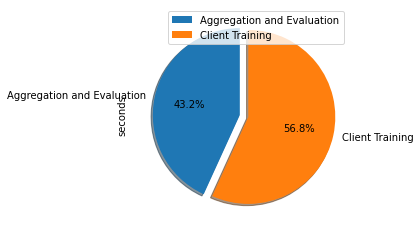

In [111]:
df_ = fedless_df.loc[("mnist", slice(100, 100)), :]
df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]
df_warm_ = df_[df_["round"] > 0]

vals = []
cols = ["aggregator_seconds", "time_clients_fit"]#, "time_remaininig"]
for col in cols:
    vals.append((col, df_warm_[col].mean()))

timing_df_ = pd.DataFrame(vals, columns=["type", "seconds"])
 # , "Rest"
timing_df_.plot.pie(y="seconds", labels=["Aggregation and Evaluation", "Client Training"], autopct='%1.1f%%', shadow=True, startangle=90, explode=[0.0, 0.1],
                   x="clients_in_round")
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

<ipython-input-112-982f1a0c4771>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = fedless_client_df.loc[("mnist", 100)]


<AxesSubplot:xlabel='state', ylabel='seconds'>

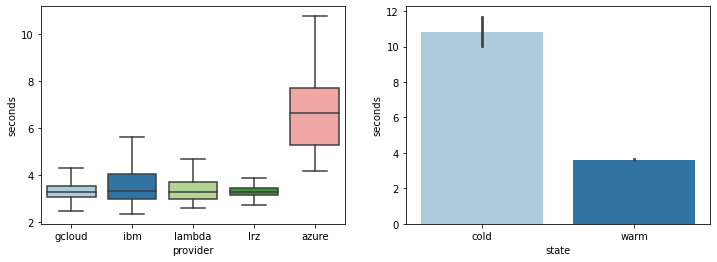

In [112]:
df_ = fedless_client_df.loc[("mnist", 100)]
df_ = df_[df_["eval"] == False]
df_["state"] = df_["round"].map(lambda r: "cold" if (r < 1) else "warm")
df_["fun_obj"] = df_["function"].map(lambda x: json.loads(x))
df_["provider"] = df_["fun_obj"].map(lambda x: x["type"] if x["type"] != "openwhisk-web" else ("ibm" if "ibm" in x["params"]["endpoint"] else "lrz"))


fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
sns.boxplot(x="provider", y="seconds", data=df_, showfliers=False, palette=SNS_DEFAULT_PALETTE, ax=axarr[0])
sns.barplot(x="state", y="seconds", data=df_, palette=SNS_DEFAULT_PALETTE, ax=axarr[1]) # showfliers=False

In [ ]:
provider_runtimes = df_.groupby("provider").median("seconds")
print(provider_runtimes)

df_.groupby(["provider", "seed"]).size().groupby("provider").mean()

In [ ]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost, calc_lambda_function_cost
from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.serialization import NpzWeightsSerializer


model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
gcloud_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=7259,
                        function_runtime_seconds=3.281925,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
lambda_cost = calc_lambda_function_cost(
    memory=2048,
    invocations=7259.000000,
    function_runtime_seconds=3.301694,
    function_egress_mb=model_size,
    num_active_instances=170,
    substract_free_tier=False)

sns.barplot(x=["gcloud", "lambda"], y=[gcloud_cost, lambda_cost])

## FEMNIST

#### Accuracy over Rounds

In [ ]:
df_ = fedless_df.loc[("femnist", 100)]

sns.lineplot(x="round", y="accuracy", data=df_, palette=SNS_DEFAULT_PALETTE)

In [ ]:
df_ = fedless_df.loc[("femnist", 100)]
df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]
df_warm_ = df_[df_["round"] > 0]

vals = []
cols = ["aggregator_seconds", "time_clients_fit", "time_remaininig"]
for col in cols:
    vals.append((col, df_warm_[col].mean()))

timing_df_ = pd.DataFrame(vals, columns=["type", "seconds"])

fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))

timing_df_.plot.pie(y="seconds", labels=["Aggregation and Evaluation", "Client Training", "Evaluation"], autopct='%.1fs', 
                    shadow=True, startangle=90, explode=[0.0, 0.0, 0.0], ax=axarr[0],
                    normalize=True)
sns.violinplot(y="time", ax=axarr[1], data=df_warm_)
#sns.boxplot(y="time", ax=axarr[1], data=df_warm_, showcaps=False,widths=0.06, patch_artist=True)
df_warm_[["aggregator_seconds", "time_clients_fit", "time_remaininig"]]
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [ ]:
df_ = fedless_client_df.loc[("femnist", 100)]
df_ = df_[df_["eval"] == False]

fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
sns.boxplot(x="provider", y="seconds", data=df_, showfliers=False, palette=SNS_DEFAULT_PALETTE, ax=axarr[0])
sns.barplot(x="state", y="seconds", data=df_, palette=SNS_DEFAULT_PALETTE, ax=axarr[1]) # showfliers=False

In [ ]:
df_ = fedless_client_df.loc[("femnist", 100)]
df_ = df_[df_["eval"] == False]
provider_runtimes = df_.groupby("provider").median("seconds")
print(provider_runtimes)

df_.groupby(["provider", "seed"]).size().groupby("provider").mean()

In [2]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost
from fedless.benchmark.leaf import create_femnist_cnn, create_shakespeare_lstm
from fedless.serialization import NpzWeightsSerializer

#model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_shakespeare_lstm().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=1000,
                        function_runtime_seconds=300,
                        function_egress_mb=model_size,
                        substract_free_tier=False)

9.0842876171875

In [5]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost
from fedless.benchmark.leaf import create_femnist_cnn, create_shakespeare_lstm
from fedless.serialization import NpzWeightsSerializer

#model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_shakespeare_lstm().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=1000,
                        function_runtime_seconds=200,
                        function_egress_mb=model_size,
                        substract_free_tier=False)

6.1842876171875005